# Title: msticpy - Data
## Description:
This package provides functions to allow for the defining of data sources, connectors to them, and queries for them as well as the ability to call these elements to return query result from the defined data sources.
The package currently support connections to Log Analytics/Azure Sentinel/Azure Security Center, and the Microsoft Security Graph.

The first step in using this package is to install the msticpy package.

In [26]:
!pip install git+https://github.com/microsoft/msticpy@pebryanDataLibraryReview --upgrade --user

  Cloning https://github.com/microsoft/msticpy (to revision pebryanDataLibraryReview) to c:\users\pebryan\appdata\local\temp\pip-req-build-ijwtjk1f
Branch 'pebryanDataLibraryReview' set up to track remote branch 'pebryanDataLibraryReview' from 'origin'.
Switched to a new branch 'pebryanDataLibraryReview'
  Stored in directory: C:\Users\pebryan\AppData\Local\Temp\pip-ephem-wheel-cache-ixnicz2v\wheels\56\ce\f6\b5ccc88bc3a7e818cd459a0c6c09c6905c1006f263f15f2b15
Successfully built msticpy
  Found existing installation: msticpy 0.1.9
    Uninstalling msticpy-0.1.9:
      Successfully uninstalled msticpy-0.1.9


<a id='contents'></a>
## Table of Contents
- [Instanciating a Query Provider](#instnciating)
- [Connecting to a Data Environment](#connecting)
- [Reviewing avaliable queries](#review_queries)
- [Running a pre-defined query](#run_query)
- [Running an ad-hoc query](#run_adhoc)
- [Creating a new set of queries](#new)
- [Adding a new set of queries and running them](#add_new)

In [1]:
#Check we are running Python 3.6
import sys
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

#imports
import yaml
import msticpy.nbtools as nbtools

#data library imports
from msticpy.data.data_providers import QueryProvider
import msticpy.data.data_query_reader as QueryReader
from msticpy.data.param_extractor import extract_query_params

print('Imports Complete')


Imports Complete


<a id='instnciating'></a>
### Instanciating a Query Provider
In order to connect to and query a data source we need to define 2 main things.
1. What sort of Data Environment we want to connect to and query (in this example it is Log Analytics). The options include:
    LogAnalytics - for Connecting to a Log Analytics or Azure Sentinel workspace
    AzureSecurityCenter - for Connecting to Azure Security Center
    SecurityGraph - for Connecting to the the Microsoft Security Graph
    
2. The connection string required to connect to each of these data sources. For Log Analytics/Sentinel it is:
    loganalytics://code().tenant("TENANT ID").workspace("WORKSPACE ID")
    the other providers will have different connection strings.
    
The first thing we need to do is instanciate a Query Provider for the Data Environment we want to connect to an query. The Query Provider provides a container our queries and and query executions. The query driver and queries loaded will depend on the Data Environment defined when instanciating the Query Provider. The below code instanciates a QueryProvider for Log Analytics which will procede to load the KQL driver.

    Query provider interface to queries.

        Parameters
        ----------
        data_environment : Union[str, DataEnvironment]
            Name or Enum of environment for the QueryProvider
        driver : DriverBase, optional
            Override the builtin driver (query execution class)
            and use your own driver (must inherit from
            `DriverBase`)

      

Please wait. Loading Kqlmagic extension...



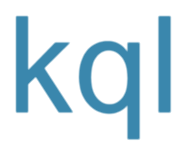

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
qry_prov = QueryProvider('LogAnalytics')

<a id='connecting'></a>
### Connecting to a Data Environment
Once we have instanciated the query provider and loaded the relevent driver we can connect to the Data Environment. This is done by calling the connect function and passing it a connection string to use.
For Log Analytics/Azure Sentinel the connection string is int he format of loganalytics://code().tenant("TENANT_ID").workspace("WORKSPACE_ID")

    connect(self, connection_str: str, **kwargs):
       
        Connect to data source.

        Parameters
        ----------
        connection_string : str
            Connection string for the data source

In [3]:
ws_id = input('Workspace ID')
ten_id = input('Tenant ID')
la_connection_string = f'loganalytics://code().tenant("{ten_id}").workspace("{ws_id}")'
qry_prov.connect(connection_str=f'{la_connection_string}')

Workspace ID b1315f05-4a7a-45b4-811f-73e715f7c122
Tenant ID 72f988bf-86f1-41af-91ab-2d7cd011db47


<IPython.core.display.Javascript object>

<a id='review_queries'></a>
### Reviewing avaliable queries
Once we have connected to the relevent Data Environment we need to look at what query options we have avaliable to us. In order to so this we can call QUERY_PROVIDER.list_queries(). This will return a generator with the names of all the queries in our store.
The results returned show the data family the query belongs to and the name of the specific query.

    list_queries(self):
        
        Return list of family.query in the store.

        Returns
        -------
        Iterable[str]
            List of queries


In [4]:
queries = qry_prov.list_queries()
for query in queries:
    print(query)

SecurityAlert.get_alert
SecurityAlert.list_alerts
SecurityAlert.list_alerts_counts
SecurityAlert.list_alerts_for_ip
SecurityAlert.list_related_alerts
WindowsSecurity.get_host_logon
WindowsSecurity.get_parent_process
WindowsSecurity.get_process_tree
WindowsSecurity.list_host_logon_failures
WindowsSecurity.list_host_logons
WindowsSecurity.list_host_processes
WindowsSecurity.list_hosts_matching_commandline
WindowsSecurity.list_matching_processes
WindowsSecurity.list_processes_in_session


To get further details on a specific query call QUERY_PROVIDER.DATA_FAMILY.QUERY_NAME('?') or QUERY_PROVIDER.DATA_FAMILY.QUERY_NAME('help')

This will display:
- Query Name
- What Data Environment it is designed for
- Short description of what the query does
- What paramater the query can be passed
- The raw query that will be run

In [5]:
qry_prov.SecurityAlert.list_alerts('?')

Query:  list_alerts
Data source:  LogAnalytics
Retrieves list of alerts

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
end: datetime
    Query end time
path_separator: str (optional)
    Path separator
    (default value is: \\)
query_project: str (optional)
    Column project statement
    (default value is:  | project-rename StartTimeUtc = StartTime, EndTim...)
start: datetime
    Query start time
subscription_filter: str (optional)
    Optional subscription/tenant filter expression
    (default value is: true)
table: str (optional)
    Table name
    (default value is: SecurityAlert)
Query:
 {table} {query_project} | where {subscription_filter} | where TimeGenerated >= datetime({start}) | where TimeGenerated <= datetime({end}) | extend extendedProps = parse_json(ExtendedProperties) | extend CompromisedEntity = tostring(extendedProps["Compromised Host"]) | project-away extendedProps {add_query_items}


<a id='run_query'></a>
### Running an pre-defined query
To call a query we again call QUERY_PROVIDER.DATA_FAMILY.QUERY_NAME(**Kwargs) but this time we simply pass required parameters for that query as key word arguements.
This will return a Pandas DataFrame of the results with the columns determined by the query parameters.

In [6]:
alerts = qry_prov.SecurityAlert.list_alerts(start='2019-06-16 00:29:29.645921', end='2019-06-19 15:36:08.620516')
alerts.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,...,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,Type,CompromisedEntity
0,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-16 00:37:37,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,c4e5e633-f8a1-42fd-ac7e-1a4a3fd69497,2518416611991069522_c4e5e633-f8a1-42fd-ac7e-1a...,...,"{\r\n ""Activity start time (UTC)"": ""2019/06/1...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
1,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-16 00:37:37,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,c4e5e633-f8a1-42fd-ac7e-1a4a3fd69497,72b658e2-5f43-489c-b4de-5dab56a2a4e1,...,"{\r\n ""Activity start time (UTC)"": ""2019/06/1...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
2,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-17 07:35:02,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,b0bc84fc-d9dc-4cce-a651-ef704c7b839d,2518415495594616834_b0bc84fc-d9dc-4cce-a651-ef...,...,"{\r\n ""Activity start time (UTC)"": ""2019/06/1...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
3,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-17 07:35:02,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,b0bc84fc-d9dc-4cce-a651-ef704c7b839d,217b6dc1-8149-4fdd-a74d-34f2be9c9be7,...,"{\r\n ""Activity start time (UTC)"": ""2019/06/1...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,
4,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-19 13:55:39,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,c0306986-d87d-45b3-be74-dfd350eeb8f0,b0fc7294-3aac-4f69-9f60-386bbfdeec4c,...,"{\r\n ""Activity start time (UTC)"": ""2019/06/1...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert,


<a id='run_adhoc'></a>
###  Running an ad-hoc query
It is also possible to run ad-hoc queries via a similar method. Rather than calling a name query from the Query Provider query store, we can pass a query directly to our Query Provider with QUERY_PROVIDER._query_provider.query(query=QUERY_STRING). This will execute the query string passed in the parameters with the driver contained in the Query Provider and return data in a Pandas DataFrame

    query(self, query: str) -> Union[pd.DataFrame, Any]:
        Execute query string and return DataFrame of results.

        Parameters
        ----------
        query : str
            The kql query to execute

        Returns
        -------
        Union[pd.DataFrame, results.ResultSet]
            A DataFrame (if successfull) or
            Kql ResultSet if an error.


In [6]:
test_query = '''
    SecurityAlert
    | take 5
    '''

query_test = qry_prov._query_provider.query(query=test_query)
query_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,DisplayName,AlertName,AlertSeverity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,...,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,Type
0,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-16 00:37:37,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,c4e5e633-f8a1-42fd-ac7e-1a4a3fd69497,2518416611991069522_c4e5e633-f8a1-42fd-ac7e-1a...,...,"[\r\n ""1. Enforce the use of strong passwords...","{\r\n ""Activity start time (UTC)"": ""2019/06/1...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert
1,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-16 00:37:37,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,c4e5e633-f8a1-42fd-ac7e-1a4a3fd69497,72b658e2-5f43-489c-b4de-5dab56a2a4e1,...,"[\r\n ""1. Enforce the use of strong passwords...","{\r\n ""Activity start time (UTC)"": ""2019/06/1...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert
2,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-21 23:34:49,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,f9fad35f-da3d-46a0-aad6-c318fd6a2347,3c8722a4-bfad-4993-9a81-011619aab93a,...,"[\r\n ""1. Enforce the use of strong passwords...","{\r\n ""Activity start time (UTC)"": ""2019/06/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert
3,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-21 23:34:49,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,f9fad35f-da3d-46a0-aad6-c318fd6a2347,2518411463995923982_f9fad35f-da3d-46a0-aad6-c3...,...,"[\r\n ""1. Enforce the use of strong passwords...","{\r\n ""Activity start time (UTC)"": ""2019/06/2...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert
4,b1315f05-4a7a-45b4-811f-73e715f7c122,2019-06-09 23:34:29,Suspicious authentication activity,Suspicious authentication activity,Medium,"Although none of them succeeded, some of them ...",Detection,Microsoft,24e105a6-7cf4-4fd1-b60b-0ad2da573cad,d38aed75-ada3-4449-ac11-8911d53fb103,...,"[\r\n ""1. Enforce the use of strong passwords...","{\r\n ""Activity start time (UTC)"": ""2019/06/0...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"":...",Detection,3b701f84-d04b-4479-89b1-fa8827eb537e,sentineltest,"[\r\n {\r\n ""Href"": ""https://interflowwebp...",Azure Security Center,,SecurityAlert


<a id='new'></a>
### Creating a new set of queries
msticpy provides a number of pre-defined queries to call with using the data package. You can also add in additional queries to be imported and used by your Query Provider, these are defined in YAML format files and examples of these files can be found at the msticpy GitHub site https://github.com/microsoft/msticpy/tree/master/msticpy/data/queries. 
The required structure of these query definition files is as follows:
- metadata
    - version: The version number of the definition file
    - description: A description of the purpose of this collection of query definitions
    - data_environments[]: A list of the Data Envrionments that the defined queries can be run against (1 or more)
    - data_families[]: A list of Data Families the defiend queries related to, these families are defined as part of misticpy.nbtools.query_defns
    - tags[]: A list of tags to help manage definition files
- defaults: A set of defaults that apply to all queries in the file
    - metadata: Metadata regarding a query
        - data_source: The data source to be used for the query
    - parmaters: Parameters to be passed to the query
        - name: The paramter name
        - decription: A description of what the paramter is
        - type: The data type of the parameter
        - default: The default value for that parameter
- sources: a set of queries
    - name: The name of the query
        -description: A description of the query's function
        -metadata: Any metadata assocaited with the query
        -args: The arguments of the query
            -query: The query to be executed
            -uri: A URI associated with the query
        -parameters: Any parameters required by the query not covered by defaults
            - name: The paramter name
            - decription: A description of what the paramter is
            - type: The data type of the parameter
            - default: The default value for that parameter
            

There are also a number of tools within the package to assit in validating new query definition files once created.
    
    data_query_reader.find_yaml_files
        
        Return iterable of yaml files found in `source_path`.

        Parameters
        ----------
        source_path : str
            The source path to search in.
        recursive : bool, optional
            Whether to recurse through subfolders.
            By default False

        Returns
        -------
        Iterable[str]
            File paths of yanl files found.
            
     data_query_reader.validate_query_defs
         
         Validate content of query definition.

        Parameters
        ----------
        query_def_dict : dict
            Dictionary of query definition yaml file contents.

        Returns
        -------
        bool
            True if validation succeeds.

        Raises
        ------
        ValueError
            The validation failure reason is returned in the
            exception message (arg[0])

validate_query_defs does not perform comprehensive checks on the file but does check key elements required in the file are present.

In [7]:
#list query files found in the repository defined
query_files = QueryReader.find_yaml_files(source_path="C:\\queries")
    
#Validate a each file in the directory
for file in query_files:
    with open(file) as f_handle:
        yaml_file = yaml.safe_load(f_handle)
        if QueryReader.validate_query_defs(query_def_dict = yaml_file) == True:
            print(f' {file} is a valid query definition')
        else:
            print(f'There is an error with {file}')

 C:\queries\kql_sent_linuxsyslog_activity.yaml is a valid query definition
 C:\queries\kql_sent_linuxsyslog_logon.yaml is a valid query definition


<a id='add_new'></a>
### Adding a new set of queries and running them
Once you are happy with a query definition file then you import it with QUERY_PROVIDER.import_query_file(query_file='PATH_TO_QUERY_FILE')
This will load the query file into the Query Provider's Query Store from where it can be called.

In [8]:
qry_prov.import_query_file(query_file='C:\\queries\\kql_sent_linuxsyslog_logon.yaml')
qry_prov.import_query_file(query_file='C:\\queries\\kql_sent_linuxsyslog_activity.yaml')

Once imported the queries in the files appear in the Query Provider's Query Store along side the others and can be called in the same manner.

In [9]:
queries = qry_prov.list_queries()
for query in queries:
    print(query)

LinuxSyslog.all_sylog
LinuxSyslog.cron_activity
LinuxSyslog.sudo_activity
LinuxSyslog.user_group_activity
LinuxSyslog.user_logon
SecurityAlert.get_alert
SecurityAlert.list_alerts
SecurityAlert.list_alerts_counts
SecurityAlert.list_alerts_for_ip
SecurityAlert.list_related_alerts
WindowsSecurity.get_host_logon
WindowsSecurity.get_parent_process
WindowsSecurity.get_process_tree
WindowsSecurity.list_host_logon_failures
WindowsSecurity.list_host_logons
WindowsSecurity.list_host_processes
WindowsSecurity.list_hosts_matching_commandline
WindowsSecurity.list_matching_processes
WindowsSecurity.list_processes_in_session


In [10]:
qry_prov.LinuxSyslog.cron_activity('?')

Query:  cron_activity
Data source:  LogAnalytics
All cron activity

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
end: datetime
    Query end time
host_name: str
    Hostname to query for
query_project: str (optional)
    Column project statement
    (default value is:  | project TenantId, Computer, Facility, TimeGener...)
start: datetime
    Query start time
subscription_filter: str (optional)
    Optional subscription/tenant filter expression
    (default value is: true)
table: str (optional)
    Table name
    (default value is: Syslog)
Query:
 {table} | where {subscription_filter} | where TimeGenerated >= datetime({start}) | where TimeGenerated <= datetime({end}) | where Computer == "{host_name}" | where ProcessName == "CRON" or Facility == "cron" | extend CMD=extract("CMD(.*)",1,SyslogMessage), User=extract("for user ([[:alpha:]]*)",1,SyslogMessage), CronUser=extract("^[(]([[:alpha:]]*)",1,SyslogMessage),EditStatus=extract("[A-Z]+ EDIT",0,Syslo

If you are having difficulties with a defined query and it is not producing the expected results it can be useful to see the raw query exactly as it is passed to the Data Environment. The block of code below produes the query string used for the SecurityAlert.list_alerts query.

In [11]:
# Get a copy of the raw query we are trying to execute 
query = qry_prov._query_store.get_query(data_family='SecurityAlert', query_name='list_alerts')
params, missing = extract_query_params(query, start='2019-06-16 00:29:29.645921', end='2019-06-19 15:36:08.620516')
query_string = query.create_query(**params)
print(query_string)

 SecurityAlert  | project-rename StartTimeUtc = StartTime, EndTimeUtc = EndTime, AlertDisplayName = DisplayName, Severity = AlertSeverity | extend AlertType = iif(isempty(AlertType), AlertName, AlertType) | where true | where TimeGenerated >= datetime(2019-06-16 00:29:29.645921) | where TimeGenerated <= datetime(2019-06-19 15:36:08.620516) | extend extendedProps = parse_json(ExtendedProperties) | extend CompromisedEntity = tostring(extendedProps["Compromised Host"]) | project-away extendedProps 
